In [1]:
import time
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import yaml

from hydesign.assembly.hpp_assembly import hpp_model
from hydesign.examples import examples_filepath

In [2]:
sites = pd.read_csv('hopp_input/34.22_-102.75_psmv3_60_2013.csv', index_col=0)
example = 0

ex_site = sites.iloc[int(example),:]

print('Selected example site:')
print('---------------------------------------------------')
print(ex_site.T)

longitude = float(ex_site['Longitude'])
latitude = float(ex_site['Latitude'])
altitude = float(ex_site['Elevation'])
input_ts_fn = os.path.join(os.getcwd(), 'hydesign_input/input_ts_texas.csv')
sim_pars_fn = os.path.join(os.getcwd(), 'hydesign_input/hpp_pars_converted.yml')

hpp = hpp_model(
        sim_pars_fn,
        latitude = latitude,
        longitude = longitude,
        altitude = altitude,
        num_batteries = 10,
        work_dir = './',
        input_ts_fn = input_ts_fn,
        save_battry_rf_filename='battery_rf.csv',
)

with open(sim_pars_fn, 'r') as f:
    sim_pars = yaml.safe_load(f)

inputs = dict(
clearance = sim_pars['hh'] - sim_pars['d'] / 2,
sp = (4 * sim_pars['p_rated'] * 1e6) / (np.pi * (sim_pars['d'] ** 2)),
p_rated = sim_pars['p_rated'],
Nwt	=	175,
wind_MW_per_km2 = 4.782274215,
solar_MW =	500,
surface_tilt =	50,
surface_azimuth = 210,
DC_AC_ratio	= 1 ,
b_P = 100,
b_E_h=	1,
cost_of_battery_P_fluct_in_peak_price_ratio	=0.580645161,)

Selected example site:
---------------------------------------------------
Location ID                                   543124
City                                               -
State                                              -
Country                                            -
Latitude                                       34.21
Longitude                                    -102.74
Time Zone                                         -6
Elevation                                       1178
Local Time Zone                                   -6
Clearsky DHI Units                              w/m2
Clearsky DNI Units                              w/m2
Clearsky GHI Units                              w/m2
Dew Point Units                                    c
DHI Units                                       w/m2
DNI Units                                       w/m2
GHI Units                                       w/m2
Solar Zenith Angle Units                      Degree
Temperature Units       

In [3]:
start = time.time()
outs = hpp.evaluate(**inputs)
hpp.print_design([v for k,v in inputs.items()], outs)
end = time.time()
print('exec. time [min]:', (end - start)/60 )
print(hpp.prob['NPV_over_CAPEX'])

price_t_ext = [ 6.86  6.86  6.85 ... 26.42 26.37  6.87]

Design:
---------------
clearance [m]: 17.000
sp [W/m2]: 198.861
p_rated [MW]: 6.000
Nwt: 175.000
wind_MW_per_km2 [MW/km2]: 4.782
solar_MW [MW]: 500.000
surface_tilt [deg]: 50.000
surface_azimuth [deg]: 210.000
DC_AC_ratio: 1.000
b_P [MW]: 100.000
b_E_h [h]: 1.000
cost_of_battery_P_fluct_in_peak_price_ratio: 0.581


NPV_over_CAPEX: -0.294
NPV [MEuro]: -527.738
IRR: 0.000
LCOE [Euro/MWh]: 38.723
Revenues [MEuro]: 143.715
CAPEX [MEuro]: 1796.210
OPEX [MEuro]: 36.615
Wind CAPEX [MEuro]: 1152.900
Wind OPEX [MEuro]: 27.090
PV CAPEX [MEuro]: 495.500
PV OPEX [MEuro]: 8.600
Batt CAPEX [MEuro]: 47.810
Batt OPEX [MEuro]: 0.925
Shared CAPEX [MEuro]: 100.000
Shared Opex [MEuro]: 0.000
penalty lifetime [MEuro]: 0.000
AEP [GWh]: 4574.312
GUF: 0.261
grid [MW]: 2000.000
wind [MW]: 1050.000
solar [MW]: 500.000
Battery Energy [MWh]: 100.000
Battery Power [MW]: 100.000
Total curtailment [GWh]: 0.000
Total curtailment with deg [GWh]: 0.000
Awpp [km2

In [38]:
import numpy_financial as npf
V = [-1796.210] + 25 * [143.715 - 36.615]
r = 0.06
npv = npf.npv(r, V)
npv

np.float64(-427.1125554494544)

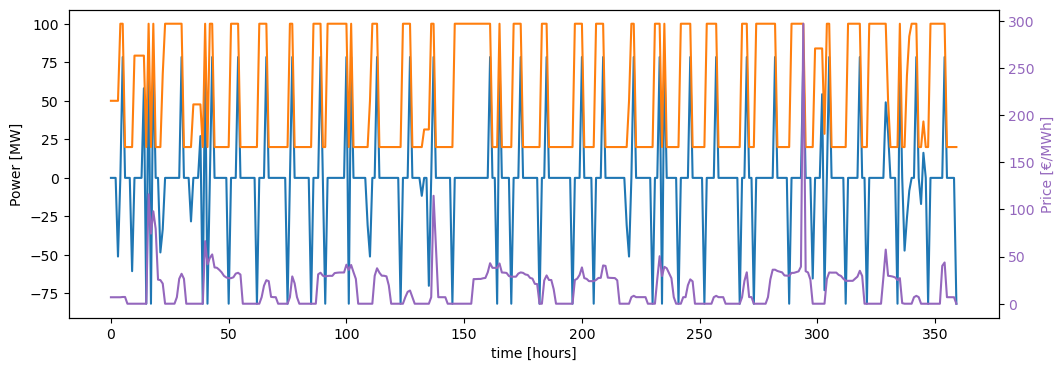

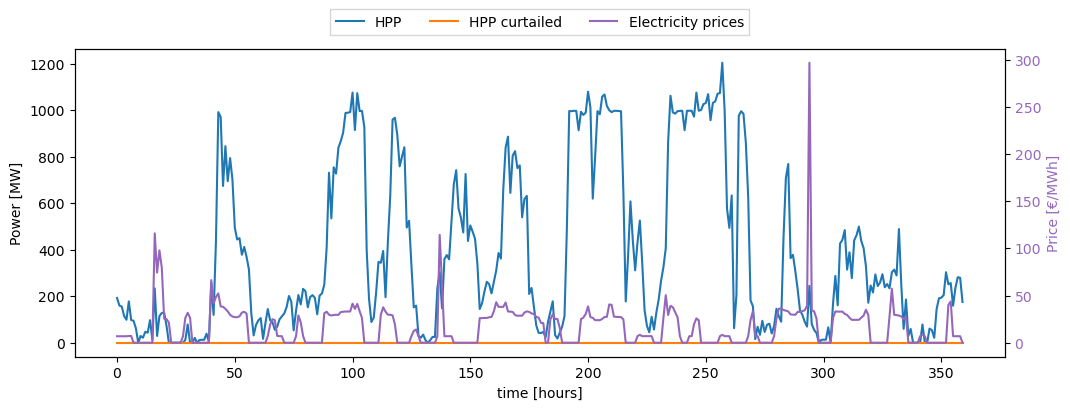

In [39]:
b_t = hpp.prob.get_val('ems.b_t')
b_E_SOC_t = hpp.prob.get_val('ems.b_E_SOC_t')
wind_t = hpp.prob.get_val('ems.wind_t')
solar_t = hpp.prob.get_val('pvp.solar_t')
hpp_t = hpp.prob.get_val('ems.hpp_t')
hpp_curt_t = hpp.prob.get_val('ems.hpp_curt_t')
price_t = hpp.prob.get_val('ems.price_t')

n_days_plot = 15

plt.figure(figsize=[12,4])
ax1 = plt.gca()
ax1.plot(b_t[:24*n_days_plot], label='Battery')
plt.plot(b_E_SOC_t[:24*n_days_plot], label='SoC [MWh]')
ax1.set_xlabel('time [hours]')
ax1.set_ylabel('Power [MW]')

ax2 = ax1.twinx()
ax2.plot(price_t[:24*n_days_plot], color='tab:purple', label='Electricity prices')
ax2.set_ylabel('Price [€/MWh]', color='tab:purple')
ax2.tick_params(axis='y', labelcolor='tab:purple')

plt.figure(figsize=[12,4])
ax1 = plt.gca()
ax1.plot(hpp_t[:24*n_days_plot], label='HPP')
ax1.plot(hpp_curt_t[:24*n_days_plot], label='HPP curtailed')
ax1.set_xlabel('time [hours]')
ax1.set_ylabel('Power [MW]')

ax2 = ax1.twinx()
ax2.plot(price_t[:24*n_days_plot], color='tab:purple', label='Electricity prices')
ax2.set_ylabel('Price [€/MWh]', color='tab:purple')
ax2.tick_params(axis='y', labelcolor='tab:purple')

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper center', 
           bbox_to_anchor=(0.5, 1.15), ncol=5, fancybox=False, shadow=False)

plt.show()

In [16]:
from hopp.simulation import HoppInterface
from hopp.tools.dispatch.plot_tools import (
    plot_battery_output, plot_battery_dispatch_error, plot_generation_profile
)

In [17]:
hi = HoppInterface(os.path.join(os.getcwd(), "hopp_input/hopp_config.yaml"))

FLORIS is the system model...


In [23]:
hi.simulate(25)

Simulating wind farm output in FLORIS...


In [24]:
hybrid_plant = hi.system

annual_energies = hybrid_plant.annual_energies
npvs = hybrid_plant.net_present_values
cf = hybrid_plant.capacity_factors
total_revenue = hybrid_plant.grid.total_revenue
revenue_gen = np.array(hybrid_plant.grid._financial_model.value('revenue_gen')) / 1e3
generation_profile = hybrid_plant.grid.generation_profile

wind_installed_cost = hybrid_plant.wind.total_installed_cost
solar_installed_cost = hybrid_plant.pv.total_installed_cost
battery_installed_cost = hybrid_plant.battery.total_installed_cost
hybrid_installed_cost = hybrid_plant.grid.total_installed_cost
OM_cost = hybrid_plant.om_total_expenses
generation_curtailed = hybrid_plant.grid.generation_curtailed

print("Wind Installed Cost [M$]: {}".format(wind_installed_cost/1e6))
print("Solar Installed Cost [M$]: {}".format(solar_installed_cost/1e6))
print("Battery Installed Cost [M$]: {}".format(battery_installed_cost/1e6))
print("Hybrid Installed Cost [M$]: {}\n".format(hybrid_installed_cost/1e6))
print("OPEX [$/year]", OM_cost)

print("Wind NPV [M$]: {}".format(hybrid_plant.net_present_values.wind/1e6))
print("Solar NPV [M$]: {}".format(hybrid_plant.net_present_values.pv/1e6))
print("Hybrid NPV [M$]: {}\n".format(hybrid_plant.net_present_values.hybrid/1e6))

print("Annual Energies [GWh]",annual_energies)
print("Capacity Factors",cf)
print("NPV [$]", npvs)
print("Total Revenue (HyDesign method) [M$]", np.sum(hpp_t[0:8760] * hpp.prob.get_val('ems.price_t')[0:8760]) / 1e6)
print("Total Revenue (HOPP method) [M$]", np.sum(np.array(hi.system.grid._financial_model.value('revenue_gen')[0:8760]) / 1e3 * np.array(hi.system.grid._financial_model.value('dispatch_factors_ts')[0:8760]) * np.array(hi.system.grid._financial_model.value('ppa_price_input'))) / 1e6)
print("Total Energy sold [GWh]", np.sum(revenue_gen) / 1e3)

print("LCOE [cents/kWh]", hybrid_plant.lcoe_real,"\n")

print(hybrid_plant.lcoe_real['hybrid'])
print("Hybrid LCOE [$/MWh]", hybrid_plant.lcoe_real['hybrid']*10)

print("Grid Curtailment [%]:", hybrid_plant.grid.curtailment_percent)

Wind Installed Cost [M$]: 1152.9
Solar Installed Cost [M$]: 495.5
Battery Installed Cost [M$]: 37.0
Hybrid Installed Cost [M$]: 1685.4

OPEX [$/year] {"pv": [0.0, 8600000.0, 8815000.0, 9035374.999999998, 9261259.374999996, 9492790.859374996, 9730110.63085937, 9973363.396630853, 10222697.481546625, 10478264.918585287, 10740221.54154992, 11008727.080088668, 11283945.257090883, 11566043.888518155, 11855194.985731106, 12151574.860374384, 12455364.231883742, 12766748.337680833, 13085917.046122853, 13413064.972275924, 13748391.59658282, 14092101.38649739, 14444403.921159824, 14805514.019188818, 15175651.869668538, 15555043.166410249], "wind": [0.0, 27090000.0, 27767249.999999996, 28461431.25, 29172967.03124999, 29902291.20703124, 30649848.487207018, 31416094.69938719, 32201497.066871874, 33006534.49354366, 33831697.85588225, 34677490.30227931, 35544427.55983628, 36433038.24883219, 37343864.20505299, 38277460.81017931, 39234397.330433786, 40215257.26369463, 41220638.69528699, 42251154.6626691

In [25]:
# Export_to_Excel time series, if needed change the time series below.
revenue_gen = np.array(revenue_gen)
hpp_t = np.array(hpp_t)

length = min(len(revenue_gen), len(hpp_t))
revenue_gen = revenue_gen[:length]
hpp_t = hpp_t[:length]

df = pd.DataFrame({
    'revenue_gen': revenue_gen,
    'hpp_t': hpp_t
})

df.to_excel('compare_ts.xlsx', index=False)

print("Export done.xlsx")

Export done.xlsx


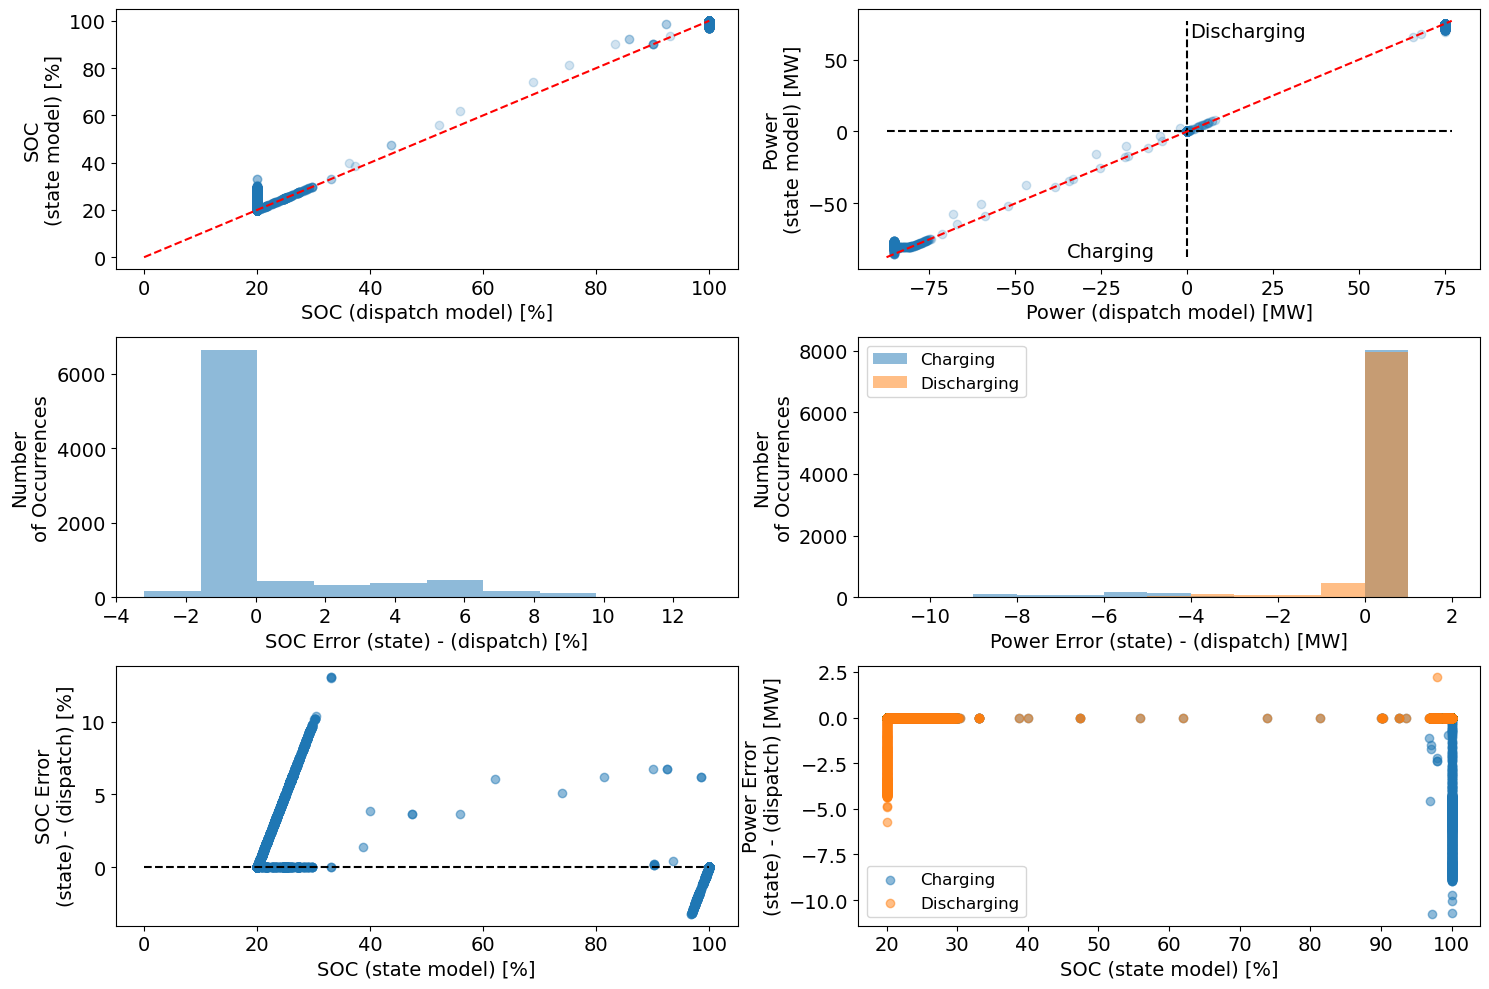

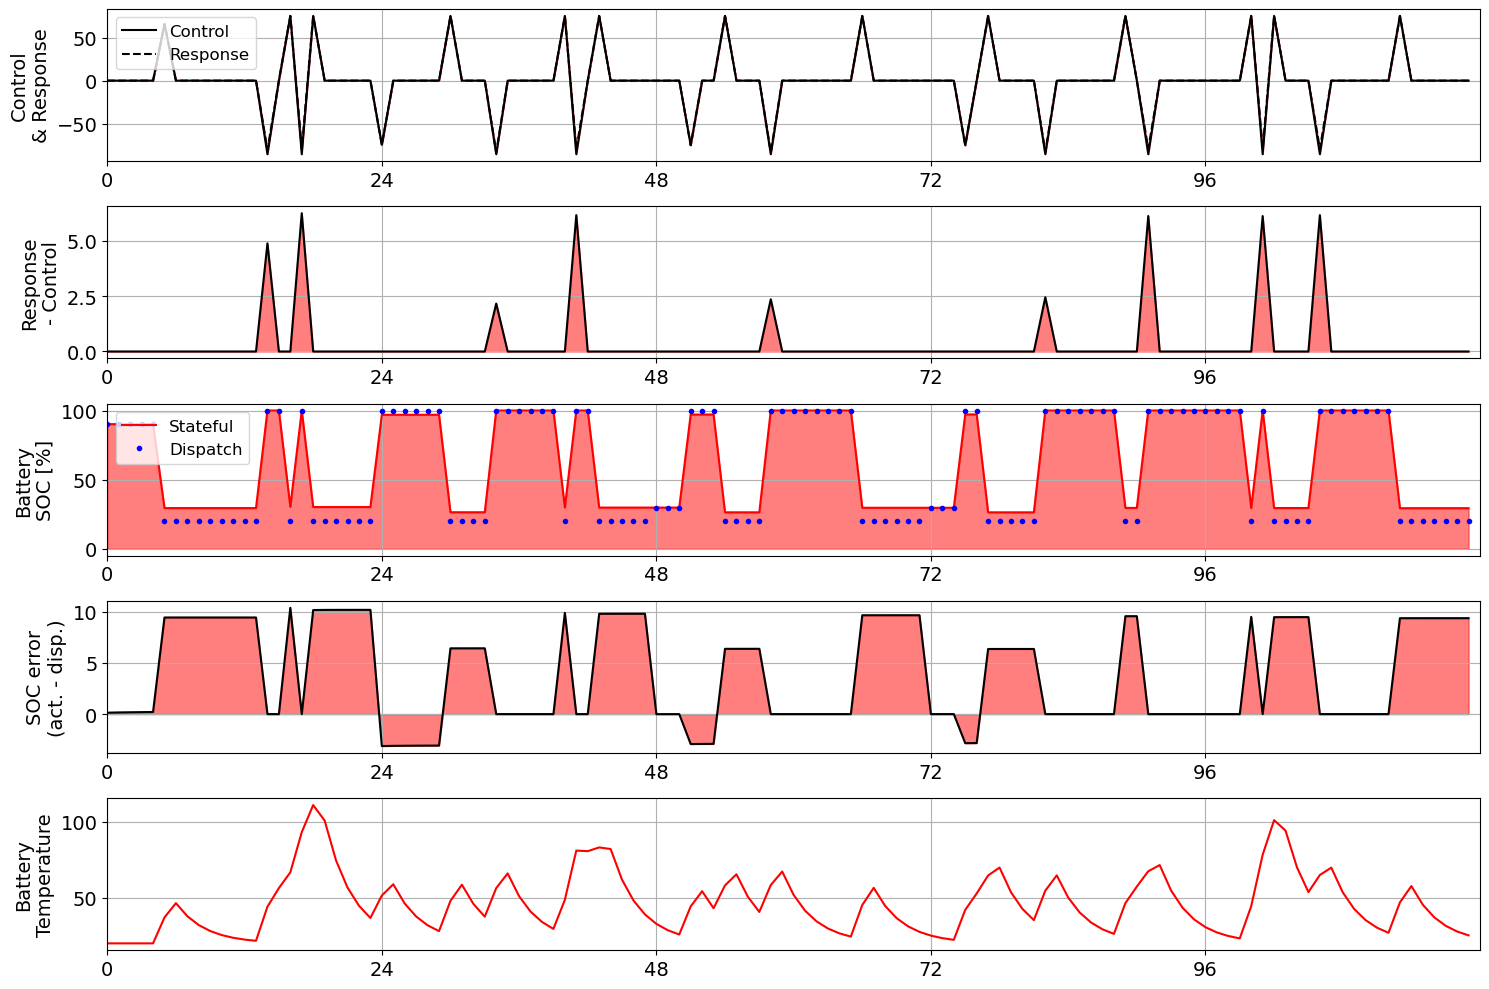

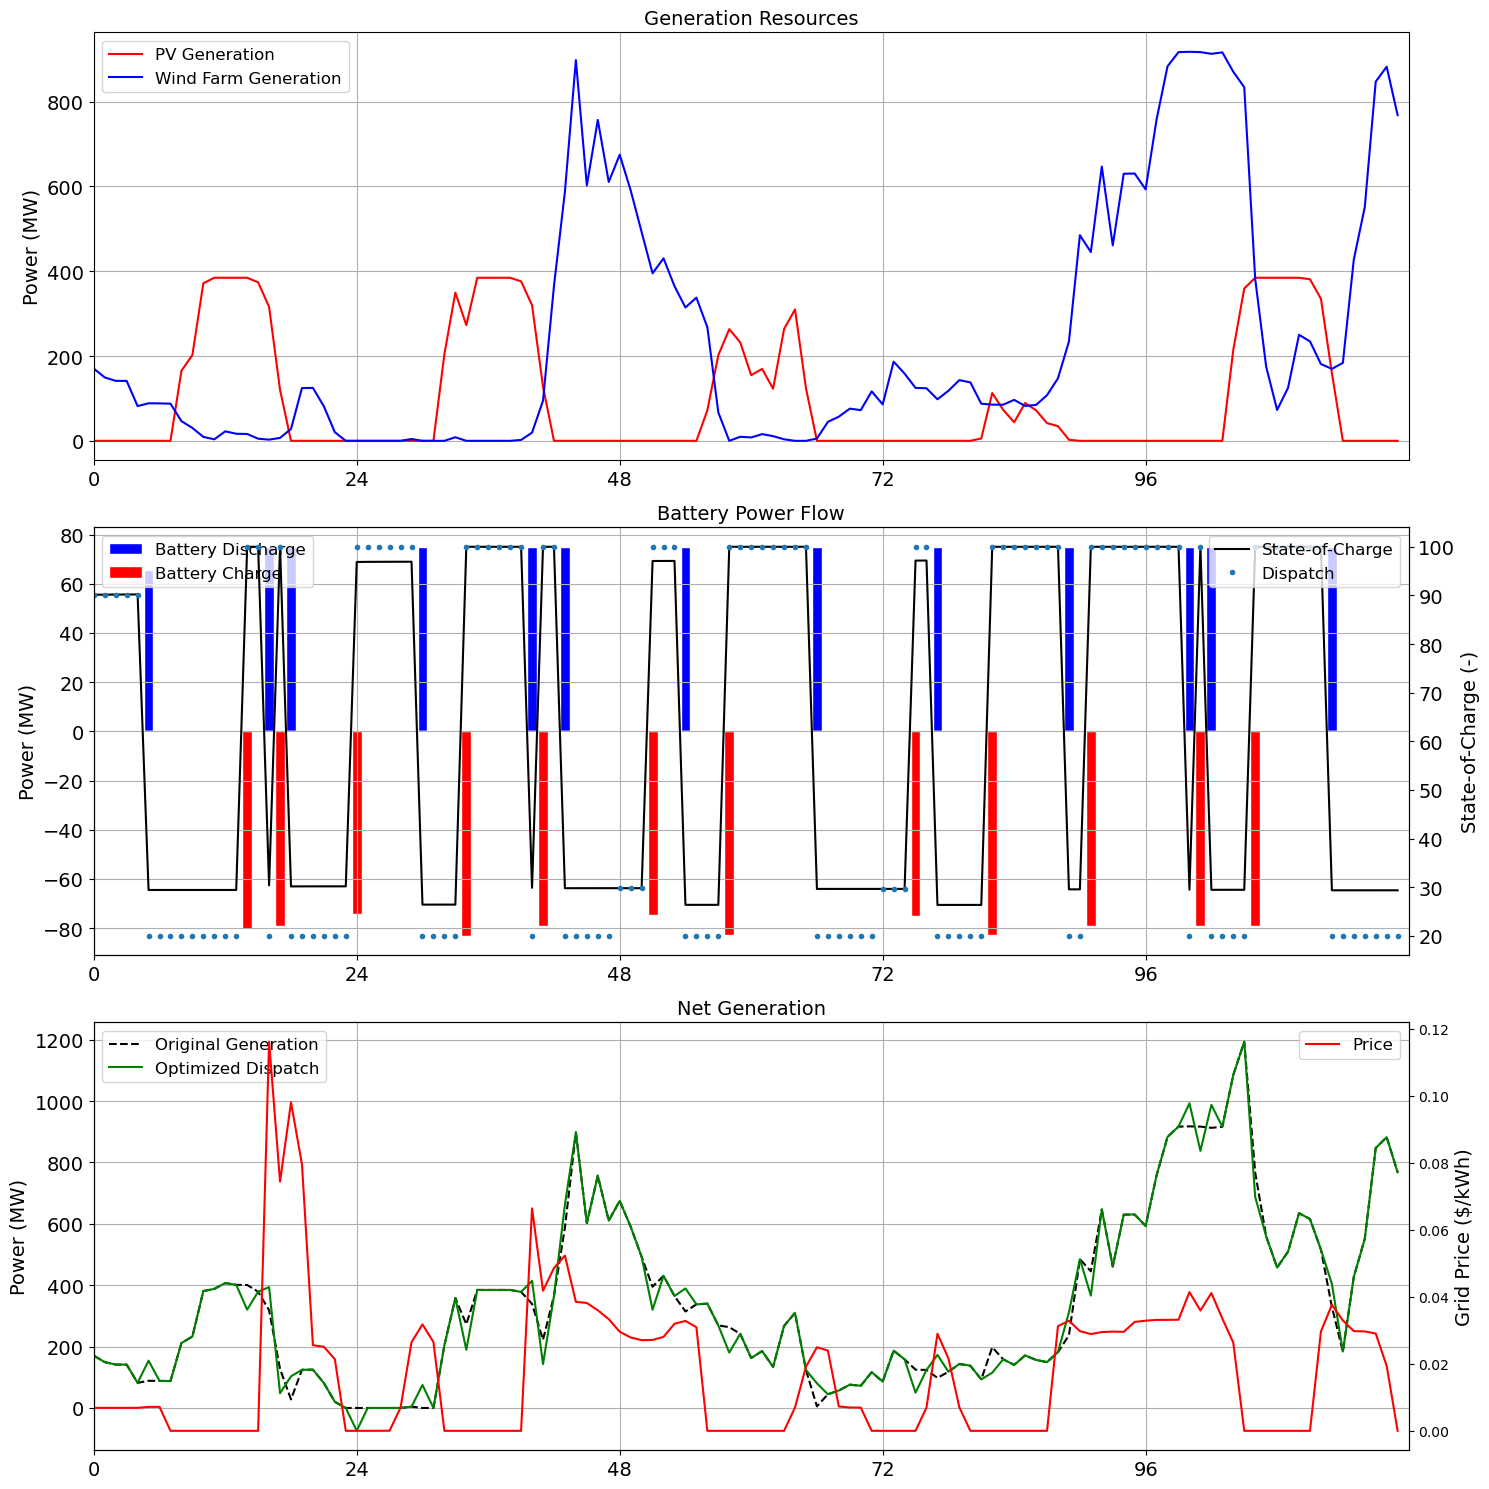

In [26]:
#Plot different battery and generation indicators/profiles in the HOPP model
plot_battery_dispatch_error(hybrid_plant)
plot_battery_output(hybrid_plant)
plot_generation_profile(hybrid_plant)

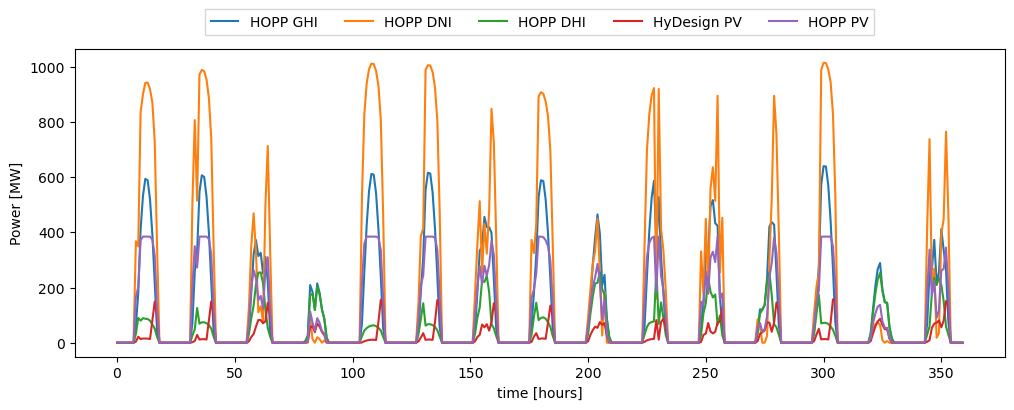

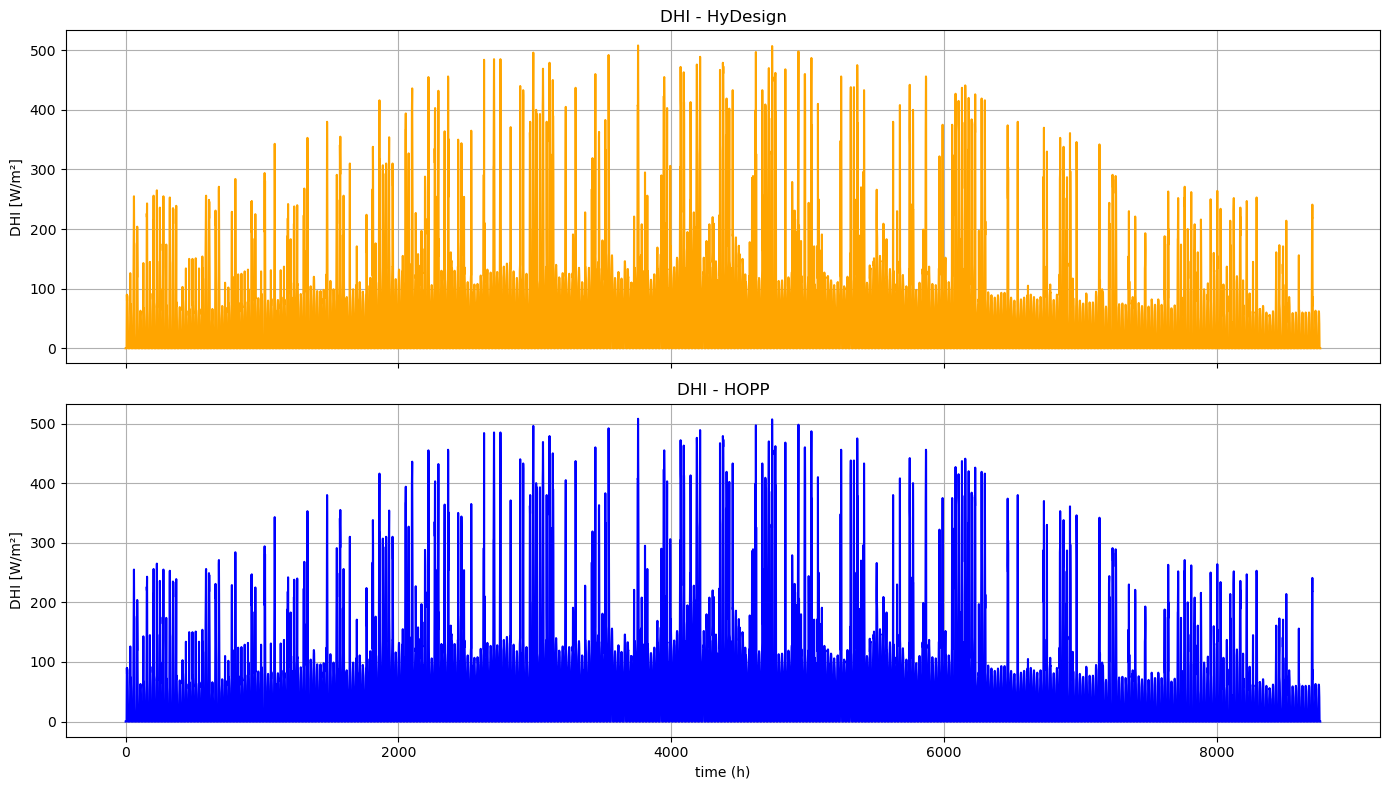

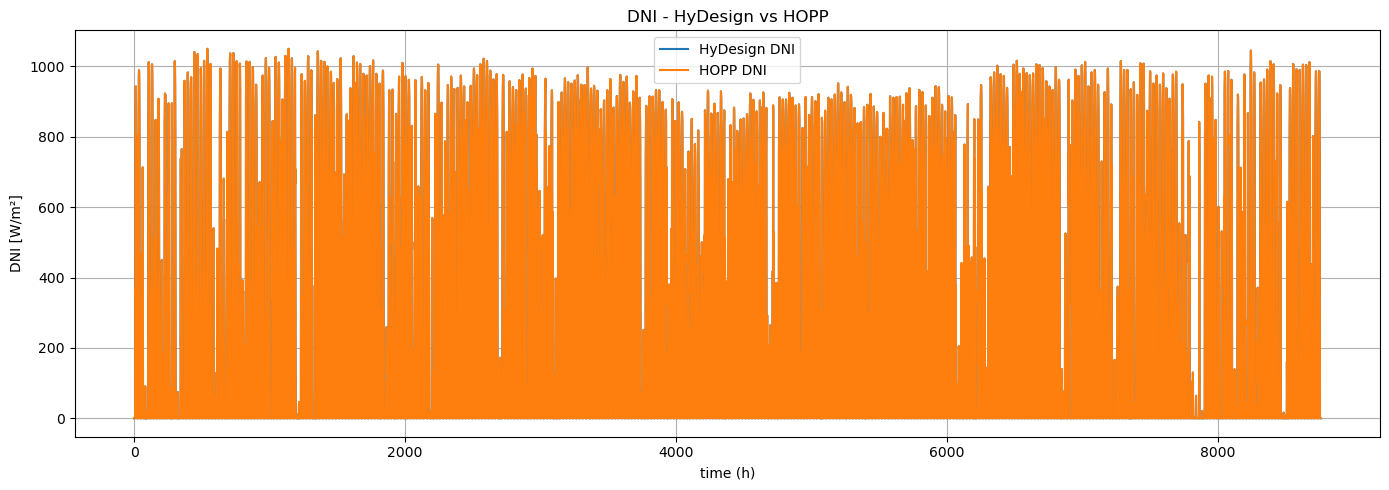

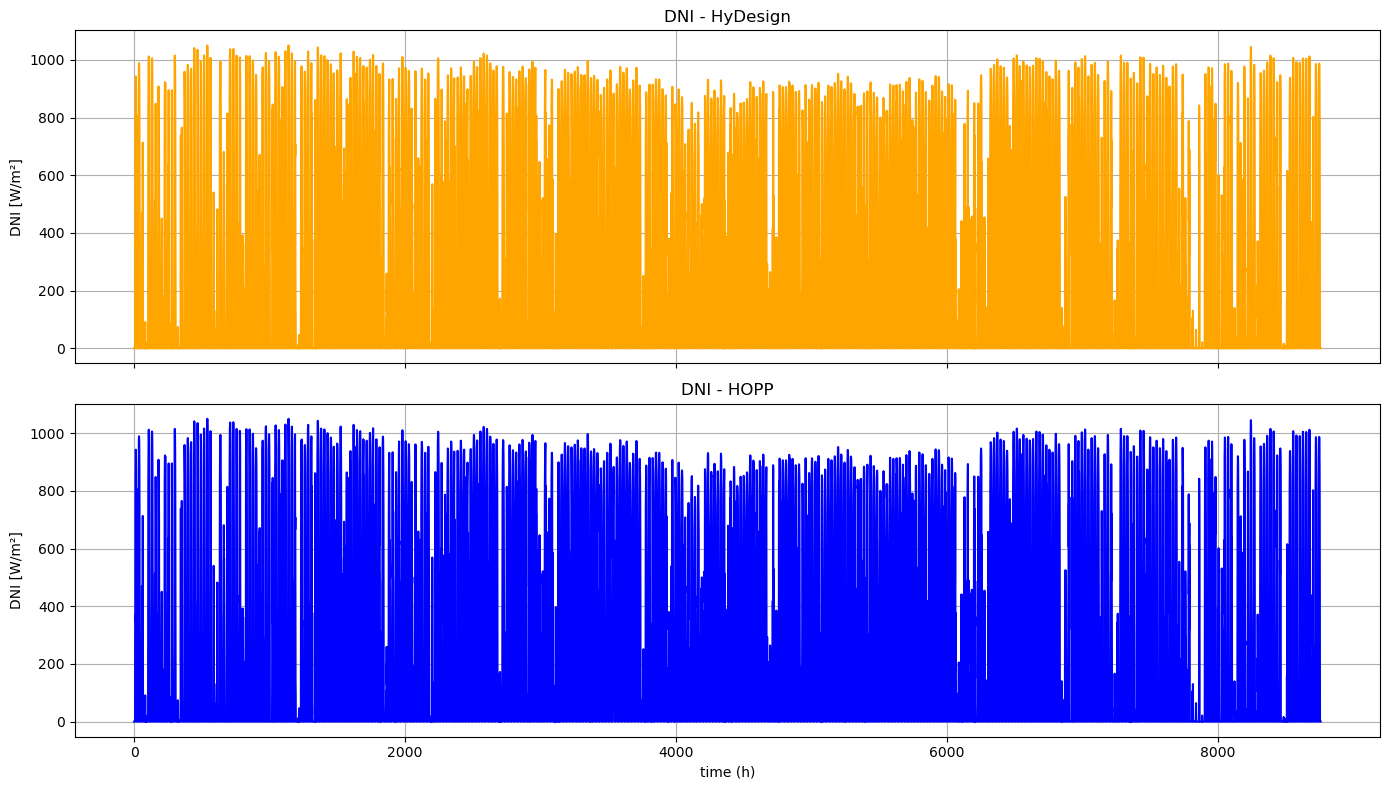

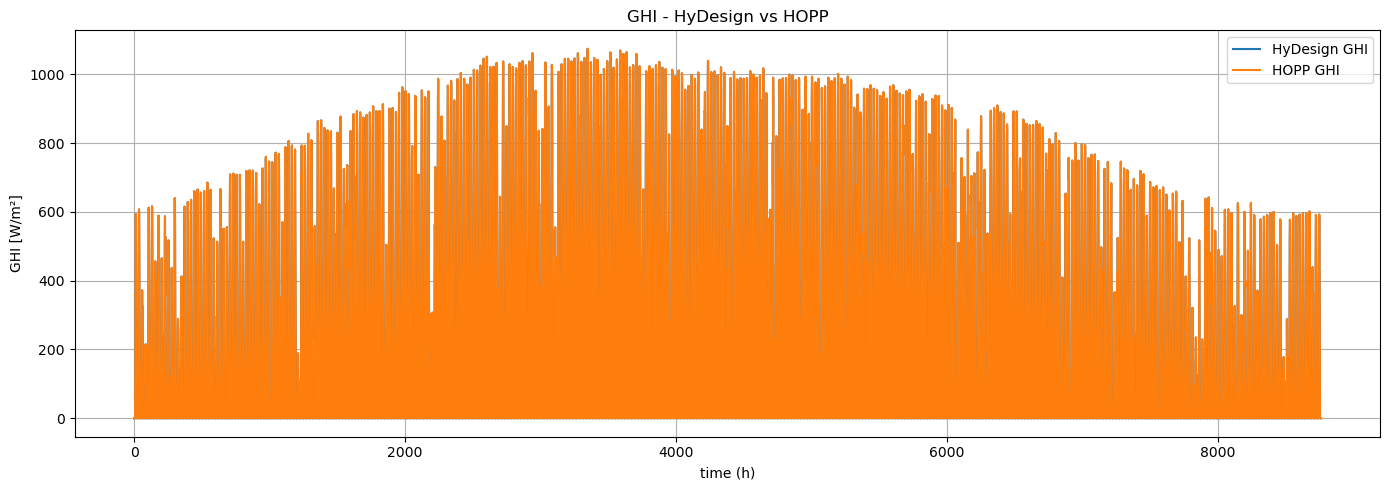

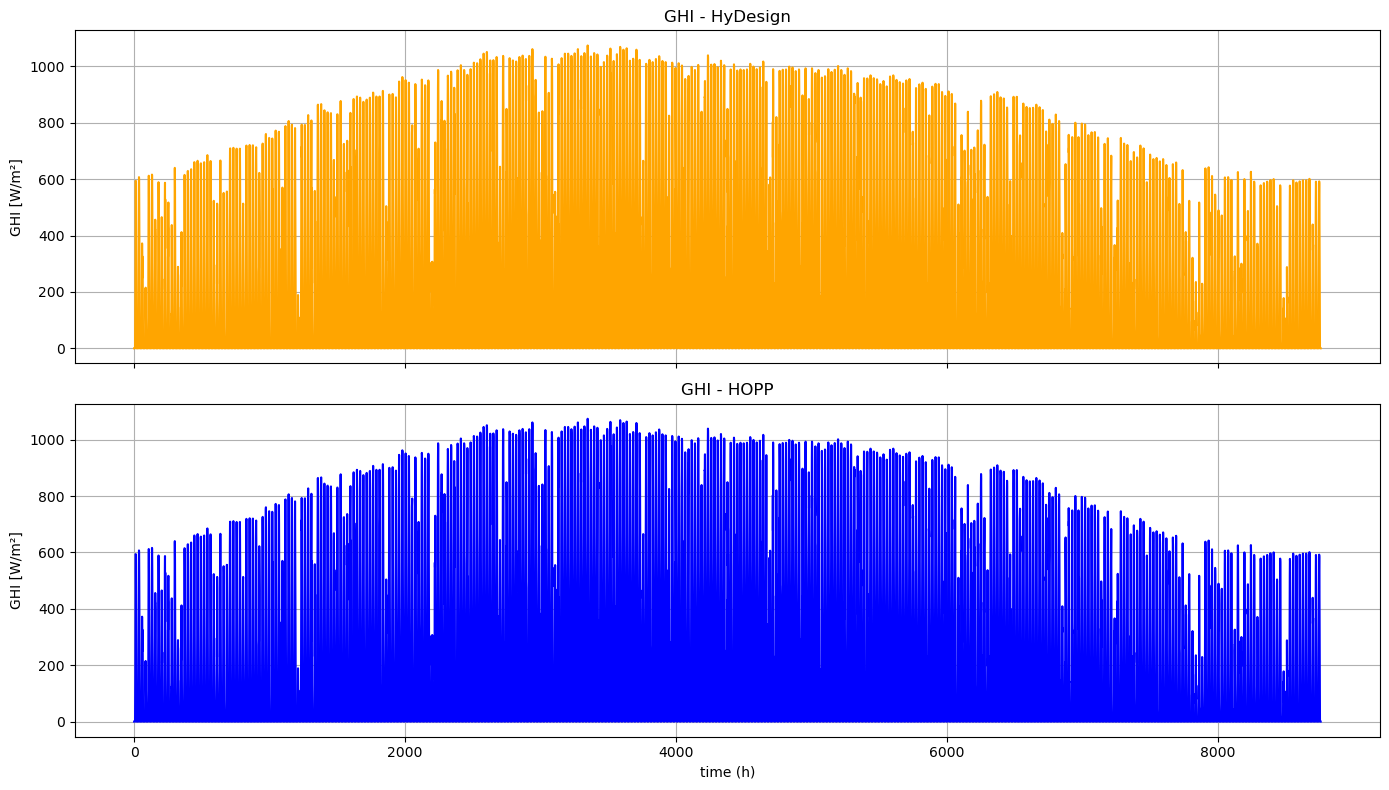

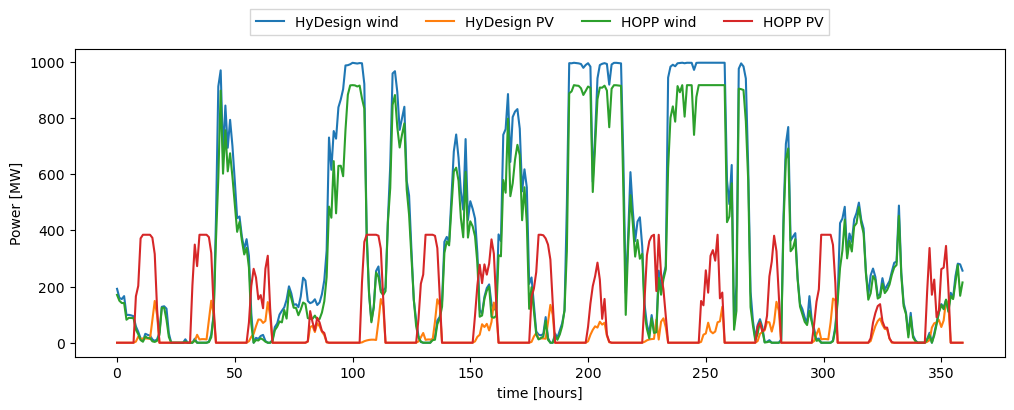

In [40]:
# Compare the wind and solar generation between HOPP and Hydesign

base_dir = os.getcwd()

folder = 'hopp_input'
file = '34.22_-102.75_psmv3_60_2013.csv'
path = os.path.join(base_dir, folder, file)
df12 = pd.read_csv(path, skiprows=[0,1])

folder = 'hopp_input'
file = '34.22_-102.75_windtoolkit_2013_60min_100m_120m.srw'
path = os.path.join(base_dir, folder, file)
df1 = pd.read_csv(path, skiprows=[0,1,3,4])

folder = 'hopp_input'
file = 'texas-price.csv'
path = os.path.join(base_dir, folder, file)
df13 = pd.read_csv(path, skiprows=[])

folder = 'hydesign_input'
file = 'input_ts_template.csv'
path = os.path.join(base_dir, folder, file)
df2 = pd.read_csv(path, index_col=0)
df3 = pd.DataFrame({'WS_100': df1['Speed'].values,
                    'WD_100': df1['Direction'].values,
                    'WS_120': df1['Speed.1'].values,
                    'WD_120': df1['Direction.1'].values,
                    'temp_air_1': df12['Temperature'].values,
                    'ghi': df12['GHI'].values,
                    'dni': df12['DNI'].values,
                    'dhi': df12['DHI'].values,
                    'Price': df13['$/MWh'].values + 1e-9,
                    }, index=df2.index)
file = 'input_ts_texas.csv'
path = os.path.join(base_dir, folder, file)
df3['temp_air_1'] = df3['temp_air_1'] + 273.15 #HOPP has degree celsius
df3.to_csv(path)

### DHI PLOT ####

plt.figure(figsize=[12,4])
ax1 = plt.gca()
ax2 = plt.gca()
ax1.plot(df12['GHI'].values[:24*n_days_plot], label='HOPP GHI')
ax1.plot(df12['DNI'].values[:24*n_days_plot], label='HOPP DNI')
ax1.plot(df12['DHI'].values[:24*n_days_plot], label='HOPP DHI')
ax2.plot(solar_t[:24*n_days_plot], label='HyDesign PV')
ax2.plot(np.array(hybrid_plant.pv.generation_profile[:24*n_days_plot]) / 1e3, label='HOPP PV')
ax1.set_xlabel('time [hours]')
ax1.set_ylabel('DHI [W/m2]')
ax2.set_ylabel('Power [MW]')
lines_1, labels_1 = ax1.get_legend_handles_labels()
ax1.legend(lines_1, labels_1, loc='upper center', 
           bbox_to_anchor=(0.5, 1.15), ncol=5, fancybox=False, shadow=False)
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

ax1.plot(df3['dhi'].values, color='orange')
ax1.set_title('DHI - HyDesign')
ax1.set_ylabel('DHI [W/m²]')
ax1.grid(True)

ax2.plot(df12['DHI'].values, color='blue')
ax2.set_title('DHI - HOPP')
ax2.set_xlabel('time (h)')
ax2.set_ylabel('DHI [W/m²]')
ax2.grid(True)

plt.tight_layout()
plt.show()

### DNI PLOT ####
plt.figure(figsize=(14, 5))
plt.plot(df3['dni'].values, label='HyDesign DNI')
plt.plot(df12['DNI'].values, label='HOPP DNI')
plt.xlabel('time (h)')
plt.ylabel('DNI [W/m²]')
plt.title('DNI - HyDesign vs HOPP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

ax1.plot(df3['dni'].values, color='orange')
ax1.set_title('DNI - HyDesign')
ax1.set_ylabel('DNI [W/m²]')
ax1.grid(True)

ax2.plot(df12['DNI'].values, color='blue')
ax2.set_title('DNI - HOPP')
ax2.set_xlabel('time (h)')
ax2.set_ylabel('DNI [W/m²]')
ax2.grid(True)

plt.tight_layout()
plt.show()

### GHI PLOT ####
plt.figure(figsize=(14, 5))
plt.plot(df3['ghi'].values, label='HyDesign GHI')
plt.plot(df12['GHI'].values, label='HOPP GHI')
plt.xlabel('time (h)')
plt.ylabel('GHI [W/m²]')
plt.title('GHI - HyDesign vs HOPP')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 8), sharex=True)

ax1.plot(df3['ghi'].values, color='orange')
ax1.set_title('GHI - HyDesign')
ax1.set_ylabel('GHI [W/m²]')
ax1.grid(True)

ax2.plot(df12['GHI'].values, color='blue')
ax2.set_title('GHI - HOPP')
ax2.set_xlabel('time (h)')
ax2.set_ylabel('GHI [W/m²]')
ax2.grid(True)

plt.tight_layout()
plt.show()

plt.figure(figsize=[12,4])
ax1 = plt.gca()
ax1.plot(wind_t[:24*n_days_plot], label='HyDesign wind')
ax1.plot(solar_t[:24*n_days_plot], label='HyDesign PV')
ax1.plot(np.array(hybrid_plant.wind.generation_profile[:24*n_days_plot]) / 1e3, label='HOPP wind')
ax1.plot(np.array(hybrid_plant.pv.generation_profile[:24*n_days_plot]) / 1e3, label='HOPP PV')
ax1.set_xlabel('time [hours]')
ax1.set_ylabel('Power [MW]')
lines_1, labels_1 = ax1.get_legend_handles_labels()
ax1.legend(lines_1, labels_1, loc='upper center', 
           bbox_to_anchor=(0.5, 1.15), ncol=5, fancybox=False, shadow=False)
plt.show()

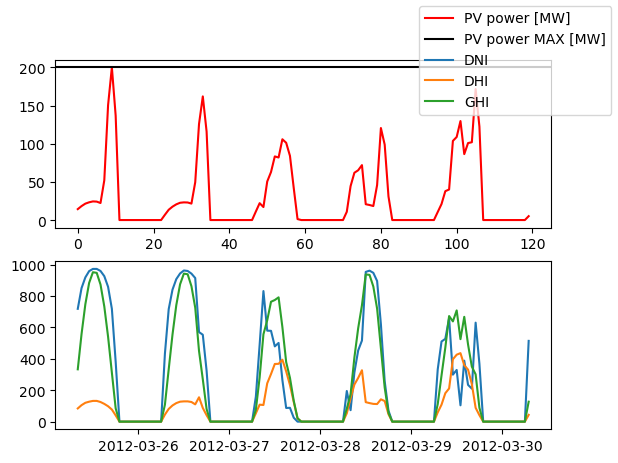

In [ ]:
import matplotlib.pyplot as plt
solar_t = hpp.prob['pvp.solar_t']
weather = hpp.prob.model.pvp.weather
dni = weather.dni
dhi = weather.dhi
ghi = weather.ghi

time_start = 2000
n_days = 5
fig, ax = plt.subplots(2,1)
ax[0].plot(solar_t[time_start: time_start + n_days * 24], color='red', label='PV power [MW]')
ax[0].axhline(200, color='black', label='PV power MAX [MW]')
ax[1].plot(dni[time_start: time_start + n_days * 24], label='DNI')
ax[1].plot(dhi[time_start: time_start + n_days * 24], label='DHI')
ax[1].plot(ghi[time_start: time_start + n_days * 24], label='GHI')
fig.legend()

In [46]:
longitude, latitude, altitude

(-102.74, 34.21, 1178.0)

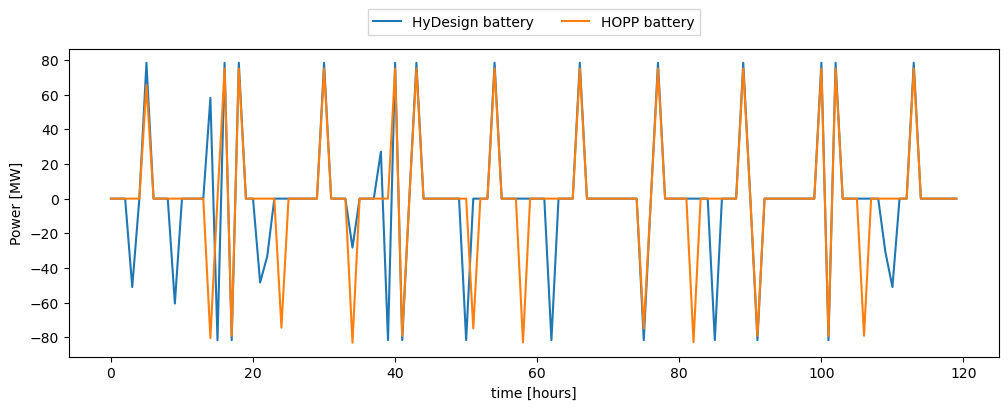

In [28]:
# Compare the battery power time series between HOPP and Hydesign
plt.figure(figsize=[12,4])
ax1 = plt.gca()
ax1.plot(b_t[:24*n_days_plot], label='HyDesign battery')
ax1.plot(np.array(hybrid_plant.battery.generation_profile[:24*n_days_plot]) / 1e3, label='HOPP battery', color='tab:orange')
ax1.set_xlabel('time [hours]')
ax1.set_ylabel('Power [MW]')
lines_1, labels_1 = ax1.get_legend_handles_labels()
ax1.legend(lines_1, labels_1, loc='upper center', 
           bbox_to_anchor=(0.5, 1.15), ncol=5, fancybox=False, shadow=False)
plt.show()

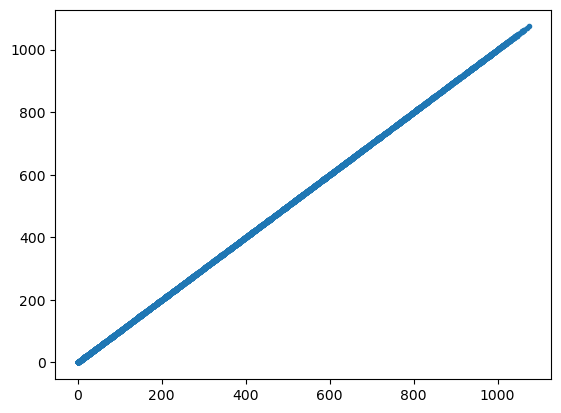

In [44]:
plt.plot(df12['GHI'].values, ghi, '.')

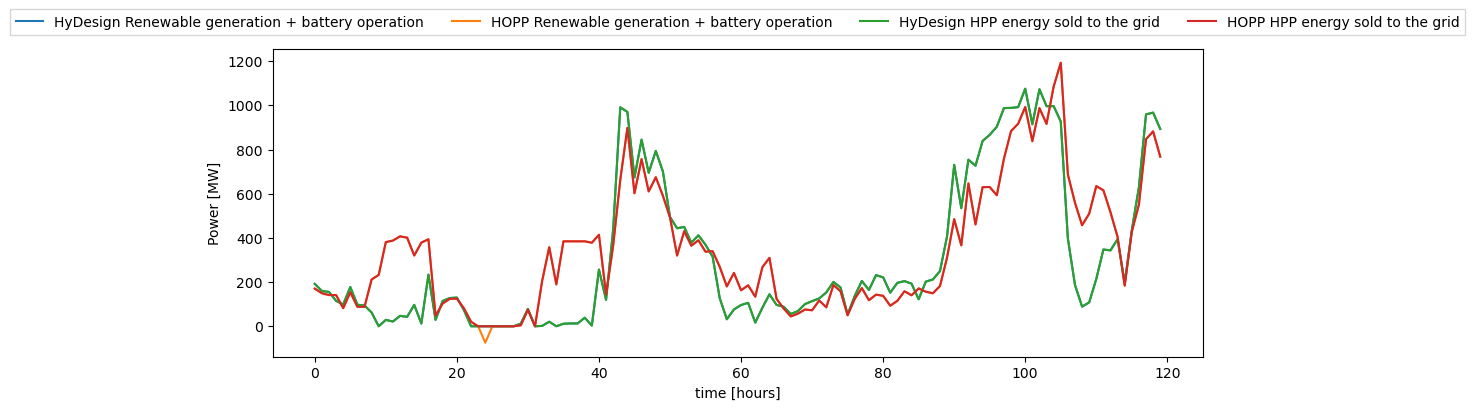

In [29]:
# Compare the sum solar + wind + battery power between HOPP and Hydesign
plt.figure(figsize=[12,4])
ax1 = plt.gca()
ax1.plot(wind_t[:24*n_days_plot] + solar_t[:24*n_days_plot] + b_t[:24*n_days_plot], label='HyDesign Renewable generation + battery operation')
ax1.plot(np.array(hybrid_plant.wind.generation_profile[:24*n_days_plot]) / 1e3 + np.array(hybrid_plant.pv.generation_profile[:24*n_days_plot]) / 1e3 + np.array(hybrid_plant.battery.generation_profile[:24*n_days_plot]) / 1e3, label='HOPP Renewable generation + battery operation')
ax1.plot(hpp_t[:24*n_days_plot], label='HyDesign HPP energy sold to the grid')
ax1.plot(revenue_gen[:24*n_days_plot], label='HOPP HPP energy sold to the grid')
ax1.set_xlabel('time [hours]')
ax1.set_ylabel('Power [MW]')
lines_1, labels_1 = ax1.get_legend_handles_labels()
ax1.legend(lines_1, labels_1, loc='upper center', 
           bbox_to_anchor=(0.5, 1.15), ncol=5, fancybox=False, shadow=False)
plt.show()


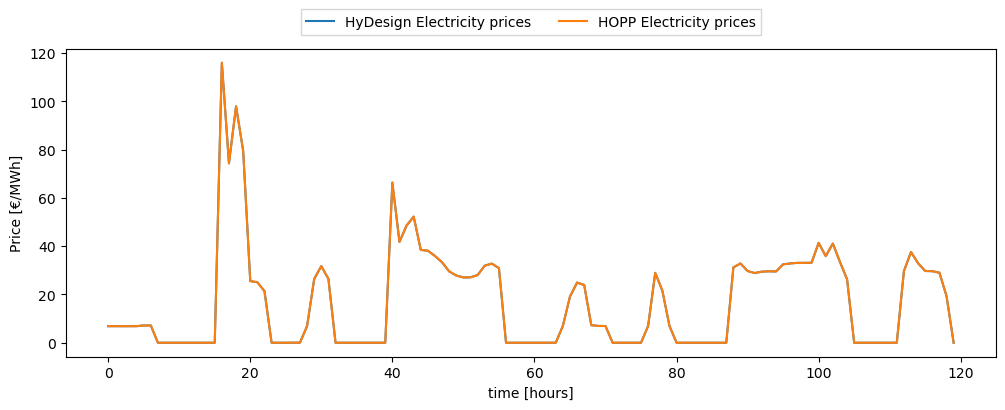

In [30]:
# Compare the electricity prices between HOPP and Hydesign
plt.figure(figsize=[12,4])
ax1 = plt.gca()
ax1.plot(price_t[:24*n_days_plot], label='HyDesign Electricity prices')
ax1.plot(np.array(hi.system.grid._financial_model.value('dispatch_factors_ts')[:24*n_days_plot]), label='HOPP Electricity prices') # Without the PPA price input ! 
ax1.set_xlabel('time [hours]')
ax1.set_ylabel('Price [€/MWh]')
lines_1, labels_1 = ax1.get_legend_handles_labels()
ax1.legend(lines_1, labels_1, loc='upper center', 
           bbox_to_anchor=(0.5, 1.15), ncol=5, fancybox=False, shadow=False)
plt.show()

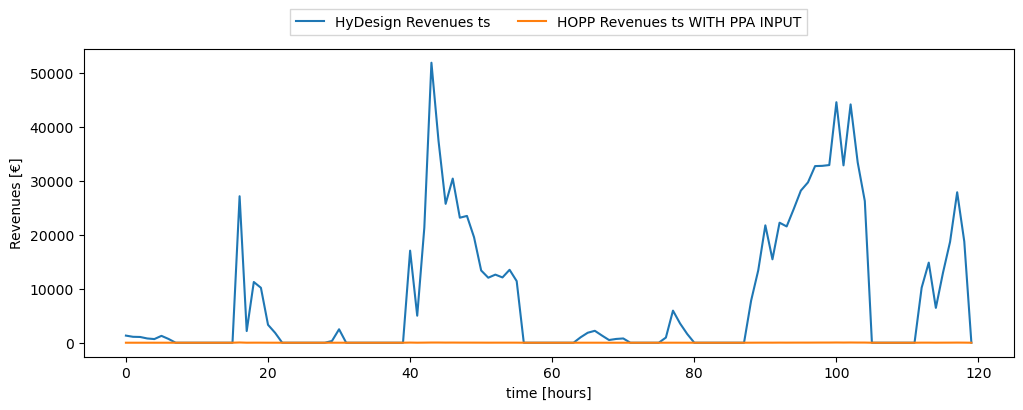

In [31]:
# Same as below. Removing the ppa price input is equivalent to shift from a price €/kWh to a price in €/MWh.
plt.figure(figsize=[12,4])
ax1 = plt.gca()
ax1.plot(hpp_t[:24*n_days_plot]*price_t[:24*n_days_plot], label='HyDesign Revenues ts')
ax1.plot(np.array(revenue_gen[:24*n_days_plot]*hi.system.grid._financial_model.value('dispatch_factors_ts')[:24*n_days_plot]) * np.array(hi.system.grid._financial_model.value('ppa_price_input')), label='HOPP Revenues ts WITH PPA INPUT') # Without the PPA price input ! 
ax1.set_xlabel('time [hours]')
ax1.set_ylabel('Revenues [€]')
lines_1, labels_1 = ax1.get_legend_handles_labels()
ax1.legend(lines_1, labels_1, loc='upper center', 
           bbox_to_anchor=(0.5, 1.15), ncol=5, fancybox=False, shadow=False)
plt.show()

In [32]:
import json

with open("singleowner.json", 'w') as f:
    dat = hybrid_plant.grid._financial_model.export()
    d = dict()
    for k, v in dat.items():
        d.update(v)
    json.dump(d, f)

In [33]:
euro_per_dollar = 1.0
df = pd.DataFrame({'HOPP': [wind_installed_cost/1e6*euro_per_dollar,
                            solar_installed_cost/1e6*euro_per_dollar,
                            battery_installed_cost/1e6*euro_per_dollar,
                            hybrid_installed_cost/1e6*euro_per_dollar,
                            hybrid_plant.net_present_values.hybrid/1e6*euro_per_dollar,
                           ],
                   'HyDesign': [float(hpp.prob['wpp_cost.CAPEX_w']/1e6),
                                float(hpp.prob['pvp_cost.CAPEX_s']/1e6),
                                float(hpp.prob['battery_cost.CAPEX_b']/1e6),
                                float(hpp.prob['CAPEX']/1e6),
                                float(hpp.prob['NPV']/1e6),
                                ] },
                  index=['CAPEX Wind [M€]',
                         'CAPEX Solar [M€]',
                         'CAPEX Battery [M€]',
                         'CAPEX Hybrid [M€]',
                         'NPV Hybrid [M€]',
                        ])

C:\Users\s223344\AppData\Local\Temp\ipykernel_19976\3229776475.py:8: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  'HyDesign': [float(hpp.prob['wpp_cost.CAPEX_w']/1e6),
C:\Users\s223344\AppData\Local\Temp\ipykernel_19976\3229776475.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(hpp.prob['pvp_cost.CAPEX_s']/1e6),
C:\Users\s223344\AppData\Local\Temp\ipykernel_19976\3229776475.py:10: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  float(hpp.prob['battery_cost

In [ ]:
df

,HOPP,HyDesign
CAPEX Wind [M€],1152.900000,1152.900000
CAPEX Solar [M€],495.500000,495.500000
CAPEX Battery [M€],37.000000,46.729154
CAPEX Hybrid [M€],1685.400000,1795.129154
NPV Hybrid [M€],498.105236,-525.169386


In [ ]:
hpp.prob.model.list_outputs()

49 Explicit Output(s) in 'model'

varname                               val                   prom_name                                   
------------------------------------  --------------------  --------------------------------------------
abl
  wst                                 |764.04689557|        abl.wst                                     
genericWT
  ws                                  |117.70938833|        genericWT.ws                                
  pc                                  |5.89355999|          genericWT.pc                                
  ct                                  |3.0492523|           genericWT.ct                                
genericWake
  pcw                                 |6097.2383766|        genericWake.pcw                             
wpp
  wind_t                              |58108.34257392|      wpp.wind_t                                  
pvp
  solar_t                             |4771.33467366|       pvp.solar_t                     

[('abl.wst',
  {'val': array([5.50530148, 5.17884758, 5.13630554, ..., 6.49699958, 7.10720779,
          7.08588905], shape=(8760,)),
   'prom_name': 'abl.wst'}),
 ('battery_cost.CAPEX_b',
  {'val': array([46729153.81638591]), 'prom_name': 'battery_cost.CAPEX_b'}),
 ('battery_cost.OPEX_b',
  {'val': array([925000.]), 'prom_name': 'battery_cost.OPEX_b'}),
 ('battery_degradation.SoH',
  {'val': array([0.9999822 , 0.9999774 , 0.99997261, ..., 0.70090711, 0.7009053 ,
          0.7009035 ], shape=(219000,)),
   'prom_name': 'battery_degradation.SoH'}),
 ('battery_degradation.n_batteries',
  {'val': array([3.]), 'prom_name': 'battery_degradation.n_batteries'}),
 ('battery_loss_in_capacity_due_to_temp.SoH_all',
  {'val': array([0.8466516 , 0.8333145 , 0.8333105 , ..., 0.61212554, 0.61212397,
          0.60277701], shape=(219000,)),
   'prom_name': 'battery_loss_in_capacity_due_to_temp.SoH_all'}),
 ('battery_with_reliability.b_t_rel',
  {'val': array([  0.        ,   0.        ,   0.        , 